# Deep Learning &mdash; Assignment 2 (update 2020.09.10)

Second assignment for the 2020 Deep Learning course (NWI-IMC058) of the Radboud University.

_Twan van Laarhoven (tvanlaarhoven@cs.ru.nl) and Gijs van Tulder (g.vantulder@cs.ru.nl)_

_September 2020_

-----

**Names:** Mick Tuit, Maurice Verbrugge

**Group:** 1

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

In this assignment you will
1. Learn how to define and train a neural network with pytorch
2. Experiment with convolutional neural networks
3. Investigate the effect of dropout and batch normalization

## Required software

If you haven't done so already, you will need to install the following additional libraries:
* `torch` and `torchvision` for PyTorch,
* `d2l`, the library that comes with [Dive into deep learning](https://d2l.ai) book,
* `sounddevice` to play audio,
* `python_speech_features` to compute MFCC features.

All libraries can be installed with `pip install`.

In [ ]:
%matplotlib inline
import os
import numpy as np
from d2l import torch as d2l
import torch
from torch import nn
from scipy.io import wavfile
from torchvision import models
from torchsummary import summary

## 2.1 Digits dataset

The d2l book uses a dataset of images as a running example (FashionMNIST). In this assignment we will investigate CNNs in a completely different domain: speech recognition.

The dataset we use is the free spoken digits dataset, which can be found on https://github.com/Jakobovski/free-spoken-digit-dataset. This dataset consists of the digits 0 to 9, spoken by different speakers. The data comes as .wav files.

**Use `git clone` to download the dataset.**

Below is a function to load the data. We pad/truncate each sample to the same length.
The raw audio is usually stored in 16 bit integers, with a range -32768 to 32767, where 0 represents no signal. Before using the data, it should be normalized. A common approach is to make sure that the data is between 0 and 1 or between -1 and 1.

**Update the below code to normalize the data to a reasonable range**

In [ ]:
samplerate = 8000
def load_waveform(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    # Take first 6000 samples from waveform. With a samplerate of 8000 that corresponds to 3/4 second
    # Pad with 0s if the file is shorter
    waveform = np.pad(waveform,(0,size))[0:size]
    # Normalize waveform
    # DONE: Your code here.
    # using RMS
    # waveform = waveform / (np.sqrt(np.sum(waveform ** 2)) + 1e-16)
    # to [-1:1]
    max_wav = max(waveform)
    waveform = waveform / max_wav
    return waveform

The following code loads all .wav files in a directory, and makes it available in a pytorch dataset.

**Load the data into a variable `data`**

In [ ]:
class SpokenDigits(torch.utils.data.Dataset):
    def __init__(self, data_dir):
        digits_x = []
        digits_y = []
        for file in os.listdir(data_dir):
            if file.endswith(".wav"):
                waveform = load_waveform(os.path.join(data_dir, file))
                label = int(file[0])
                digits_x.append(waveform)
                digits_y.append(label)
        # convert to torch tensors
        self.x = torch.from_numpy(np.array(digits_x, dtype=np.float32))
        self.x = self.x.unsqueeze(1) # One channel
        self.y = torch.from_numpy(np.array(digits_y))

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# DONE: Your code here.
data = SpokenDigits("/home/jovyan/work/deep-learning-2020-assignments/free-spoken-digit-dataset/recordings")
help(data)
print("Length of dataset is: ", len(data))
print("Dimension of a sample is: ", data.x[0].shape)
print("Number of classes are: ", len(torch.unique(data.y)))

Help on SpokenDigits in module __main__ object:

class SpokenDigits(torch.utils.data.dataset.Dataset)
 |  SpokenDigits(data_dir)
 |  
 |  An abstract class representing a :class:`Dataset`.
 |  
 |  All datasets that represent a map from keys to data samples should subclass
 |  it. All subclasses should overwrite :meth:`__getitem__`, supporting fetching a
 |  data sample for a given key. Subclasses could also optionally overwrite
 |  :meth:`__len__`, which is expected to return the size of the dataset by many
 |  :class:`~torch.utils.data.Sampler` implementations and the default options
 |  of :class:`~torch.utils.data.DataLoader`.
 |  
 |  .. note::
 |    :class:`~torch.utils.data.DataLoader` by default constructs a index
 |    sampler that yields integral indices.  To make it work with a map-style
 |    dataset with non-integral indices/keys, a custom sampler must be provided.
 |  
 |  Method resolution order:
 |      SpokenDigits
 |      torch.utils.data.dataset.Dataset
 |      built

**Describe the dataset: how many samples are there, what is their dimensionality? How many classes are there?**

DONE: your answer here.

The dataset contains 3000 samples. The dimension of a sample is \[1, 6000\] and the number of different classes is 10. 

Here is code to play samples from the dataset to give you an idea what it "looks" like.

In [ ]:
# import sounddevice as sd
# # errors on Deepnote

# def play(sample):
#     sd.play(sample[0][0], samplerate)
#     print(sample[1])
# play(data[0])

In [ ]:
train_prop = 2/3
train_count = int(len(data) * train_prop)
train, test = torch.utils.data.random_split(data, [train_count, len(data)-train_count])

The code above is code to split the data into a training and test set. It uses 2/3 of the data for training.

**Discuss an advantage and disadvantage of using more of the data for training**

DONE: your answer here.

An advantage of using more data for the training would be that it results in faster learning. A disadvantage would be that you are more likely to overfit on the training set. 

Finally, we split the data into batches:

In [ ]:
data_params = {'batch_size': 32}
train_iter = torch.utils.data.DataLoader(train, **data_params)
test_iter  = torch.utils.data.DataLoader(test,  **data_params)

## 2.2 One dimensional convolutional neural network

We will now define a network architecture. We will use a combination of convolutional layers and pooling.
Note that we use 1d convolution and pooling here, instead of the 2d operations used for images.

**Complete the network architecture, look at the d2l book chapters 6 and 7 for examples**

In [ ]:
net = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),

    # TODO: Add three more convolutional layers, ReLU layers and pooling layers;
    #       doubling the number of channels each time
    # TODO: Your code here.
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2), 

    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),

    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))

**The first fully connected layer has input dimension 11872, where does that number come from?**

In [ ]:
print(summary(net, (1, 6000)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 4, 5996]              24
              ReLU-2              [-1, 4, 5996]               0
         AvgPool1d-3              [-1, 4, 2998]               0
            Conv1d-4              [-1, 8, 2994]             168
              ReLU-5              [-1, 8, 2994]               0
         AvgPool1d-6              [-1, 8, 1497]               0
            Conv1d-7             [-1, 16, 1493]             656
              ReLU-8             [-1, 16, 1493]               0
         AvgPool1d-9              [-1, 16, 746]               0
           Conv1d-10              [-1, 32, 742]           2,592
             ReLU-11              [-1, 32, 742]               0
        AvgPool1d-12              [-1, 32, 371]               0
          Flatten-13                [-1, 11872]               0
           Linear-14                  [

DONE: your answer here

Through the convolutions and pooling layers the dimensions of the data is changed. At the first layer, the input size of 6000 is reduced by the kernel size + 1, which gives 6000-5+1=5996. The pooling layer effectively divides this by 2, resulting in 5996/2=2998. If you multiply the dimensions (32 x 371) (the flatten operation) of the the last layer before the fully connected layer you get the number 11872. 

**How many parameters are there in the model? I.e. the total number of weights and biases**

In [ ]:
# DONE: Compute the number of parameters
# Hint: use net.parameters() and param.nelement()

print('Amount of parameters in network is:', sum([param.nelement() for param in net.parameters()]))


Amount of parameters in network is: 1532090


**Suppose that instead of using convolutions, we had used only fully connected layers. How many parameters would be needed in that case approximately?**

DONE: your answer here

When using fully connected layers the dimensions of a layer are not being changed and would remain the same. So you would get (4, 5996) after the first Convolution, this would then be the same for the next 3 layers. This would mean you would have 4 * \(4 \* 5996\) parameters. Then from 23984 to 128 in a fully connected layer, then (128, 64), then a layer with (64, 10). This results in a total of 31,747,20 parameters.

The FashionMNIST dataset used in the book has 60000 training examples. How large is our training set? How would the difference affect the number of epochs that we need? Compare to chapter 6.6 and 7.1 of the book.

**How many epochs do you think are needed?**

Answer: We have 3000 training examples. The FashionMNIST training size is a factor 20 larger than our dataset, so for approximations sake we will say the number of epochs also needs to increase by a factor of 20 resulting in $10*20=200$, assuming the learning rate is the same.

In [ ]:
lr, num_epochs = 0.01, 10

We will use the code from the d2l book to train the network.
In particular, the `train_ch6` function, defined in [chapter 6.6](http://d2l.ai/chapter_convolutional-neural-networks/lenet.html#training). This function is available in the `d2l` library.
However, this function has a bug: it only initializes the weights for 2d convolutional layers, not for 1d convolutional layers.

**Make a copy of the train_ch6 function, and correct the error**

In [ ]:
def train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    # DONE: your code here (copied and corrected from train_ch6)
    """Train a model with a GPU (defined in Chapter 6)."""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv1d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            net.train()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))
    print(f'loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

    print('test')

**Now train the network.**

loss 2.288, train acc 0.163, test acc 0.153
256.9 examples/sec on cpu
test


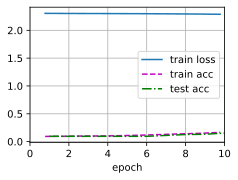

In [ ]:
train(net, train_iter, test_iter, num_epochs, lr)

**Is the training converged?**

If the training has not converged, maybe you need to change the number of epochs and/or the learning rate.

TODO: Document the changes that you made and their effect.

## 2.3 Questions and evaluation

**Does the network look like it is overfitting or underfitting?**

TODO: your answer here

**Is what we have here a good classifier? Could it be used in a realistic application?**

TODO: discuss your answer

**Do you think there is enough training data compared to the dimensions of the data and the number of parameters?**

TODO: your answer here

**How could the classifier be improved?**

TODO: your answer here

**The free spoken digits datasets has recordings from several different speakers. Is the test set accuracy a good measure of how well the trained network would perform for recognizing the voice of a new speaker? And if not, how could that be tested instead?**

TODO: your answer here.

## 2.4 Variations

One way in which the training might be improved is with dropout or with batch normalization.

**Make a copy of the network architecture below, and add dropout**

Hint: see [chapter 7.1](http://d2l.ai/chapter_convolutional-modern/alexnet.html#architecture) for an example that uses dropout.

In [ ]:
net_dropout = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),

    # TODO: Add three more convolutional layers, ReLU layers and pooling layers;
    #       doubling the number of channels each time
    # TODO: Your code here.
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2), 

    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),

    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Dropout(p=0.5), 

    nn.Linear(128, 64), nn.ReLU(),
    nn.Dropout(p=0.5)

    nn.Linear(64, 10))
    
train(net_dropout, train_iter, test_iter, num_epochs, lr)

**How does dropout change the results?**

TODO: your answer here

**Make a copy of the original network architecture, and add batch normalization to all convolutional and linear layers.**

Hint: see [chapter 7.5](http://d2l.ai/chapter_convolutional-modern/batch-norm.html#concise-implementation) for an example.

In [ ]:
net_batchnorm = torch.nn.Sequential(
    nn.Conv1d(1, 4, kernel_size=5), 
    nn.BatchNorm1d(4), nn.ReLU(),
    nn.AvgPool1d(kernel_size=2, stride=2),

    # TODO: Add three more convolutional layers, ReLU layers and pooling layers;
    #       doubling the number of channels each time
    # TODO: Your code here.
    nn.Conv1d(4, 8, kernel_size=5), nn.ReLU(),
    nn.BatchNorm1d(8), nn.ReLU()
    nn.AvgPool1d(kernel_size=2, stride=2), 

    nn.Conv1d(8, 16, kernel_size=5), nn.ReLU(),
    nn.BatchNorm1d(16), nn.ReLU()
    nn.AvgPool1d(kernel_size=2, stride=2),

    nn.Conv1d(16, 32, kernel_size=5), nn.ReLU(),
    nn.BatchNorm1d(32), nn.ReLU()
    nn.AvgPool1d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(11872, 128), nn.ReLU(),
    nn.Linear(128, 64), nn.ReLU(),
    nn.Linear(64, 10))
    
train(net_batchnorm, train_iter, test_iter, num_epochs, lr)

**How does batch normalization change the results?**

TODO: your answer here

## 2.5 Bonus: feature extraction

Given enough training data a deep neural network can learn to extract features from raw data like audio and images. However, in some cases it is still necesary to do manual feature extraction. For speech recognition, a popular class of features are [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).

Here is code to extract these features. You will need to install the `python_speech_features` first.

In [ ]:
from python_speech_features import mfcc

def load_waveform_mfcc(file, size = 6000):
    samplerate, waveform = wavfile.read(file)
    waveform = np.pad(waveform,(0,size))[0:size] / 32768
    return np.transpose(mfcc(waveform, samplerate))

**Implement a variation of the dataset that uses these features**

In [ ]:
class SpokenDigitsMFCC(torch.utils.data.Dataset):
    # TODO: Your code here.
    pass

data_mfcc = SpokenDigitsMFCC(data_dir) # TODO: your data directory here
train_count_mfcc = int(len(data_mfcc) * train_prop)
train_mfcc, test_mfcc = torch.utils.data.random_split(data, [train_count_mfcc, len(data_mfcc)-train_count_mfcc])
train_iter_mfcc = torch.utils.data.DataLoader(train_mfcc, **data_params)
test_iter_mfcc  = torch.utils.data.DataLoader(test_mfcc,  **data_params)

The MFCC features will have 13 channels instead of 1 (the `unsqueeze` operation is not needed). 

**Inspect the shape of the data, and define a new network architecture that accepts data with this shape**

In [ ]:
# Your code here.

**Train the network with the mfcc features.**

In [ ]:
# Your code here.

**Is there a neural-network based alternative to mfcc features?**

TODO: your answer here